In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az


In [35]:
# Load data
price_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/prices.csv",
    parse_dates=["date"]
)

events_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/events.csv",
    parse_dates=["date"]
)

price_df = price_df.sort_values("date").reset_index(drop=True)


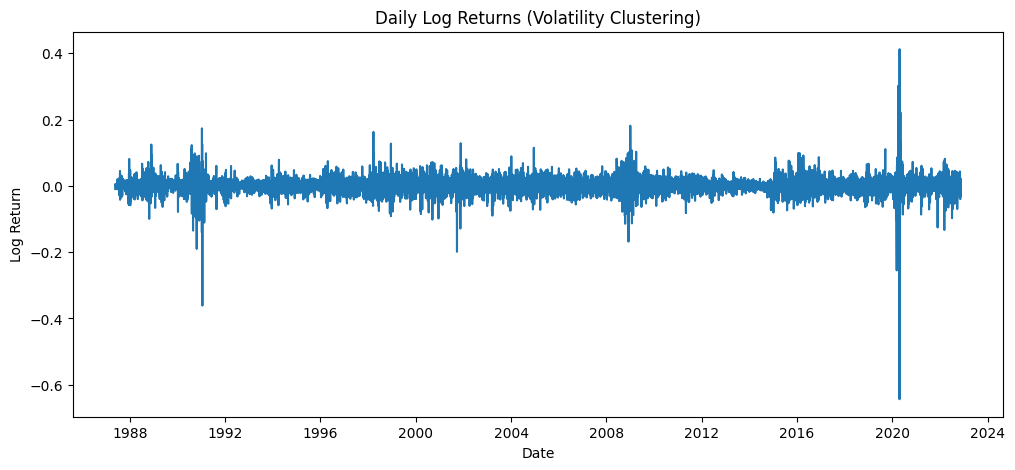

In [36]:
price_df["log_return"] = np.log(price_df["price"]).diff()

plt.figure(figsize=(12, 5))
plt.plot(price_df["date"][1:], price_df["log_return"].dropna())
plt.title("Daily Log Returns (Volatility Clustering)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [ ]:
returns = price_df["log_return"].dropna().values
n = len(returns)
idx = np.arange(n)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)

    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    mu = pm.math.switch(idx < tau, mu1, mu2)
    sigma = pm.math.switch(idx < tau, sigma1, sigma2)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

    delta_mu = pm.Deterministic("delta_mu", mu2 - mu1)

    trace = pm.sample(
        2000, tune=2000, chains=4,
        return_inferencedata=True
    )


Output()

In [ ]:
az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2", "delta_mu"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5388.753,21.608,5348.000,5423.000,0.714,0.557,1000.0,1367.0,1.01
mu1,0.000,0.000,-0.000,0.001,0.000,0.000,13463.0,5909.0,1.00
mu2,-0.000,0.000,-0.001,0.001,0.000,0.000,14946.0,6569.0,1.00
sigma1,0.023,0.000,0.023,0.023,0.000,0.000,14171.0,5726.0,1.00
sigma2,0.029,0.000,0.028,0.029,0.000,0.000,11932.0,5996.0,1.00
delta_mu,-0.000,0.001,-0.001,0.001,0.000,0.000,12982.0,6335.0,1.00


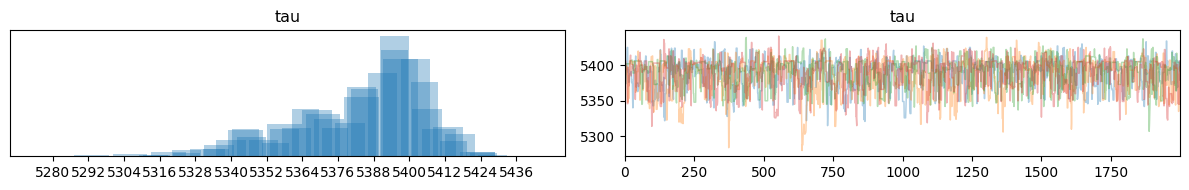

In [45]:
az.plot_trace(trace,
              var_names=["tau", "mu1", "mu2", "sigma1", "sigma2", "delta_mu"],
              combined=False,
              compact=False)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1283451021.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


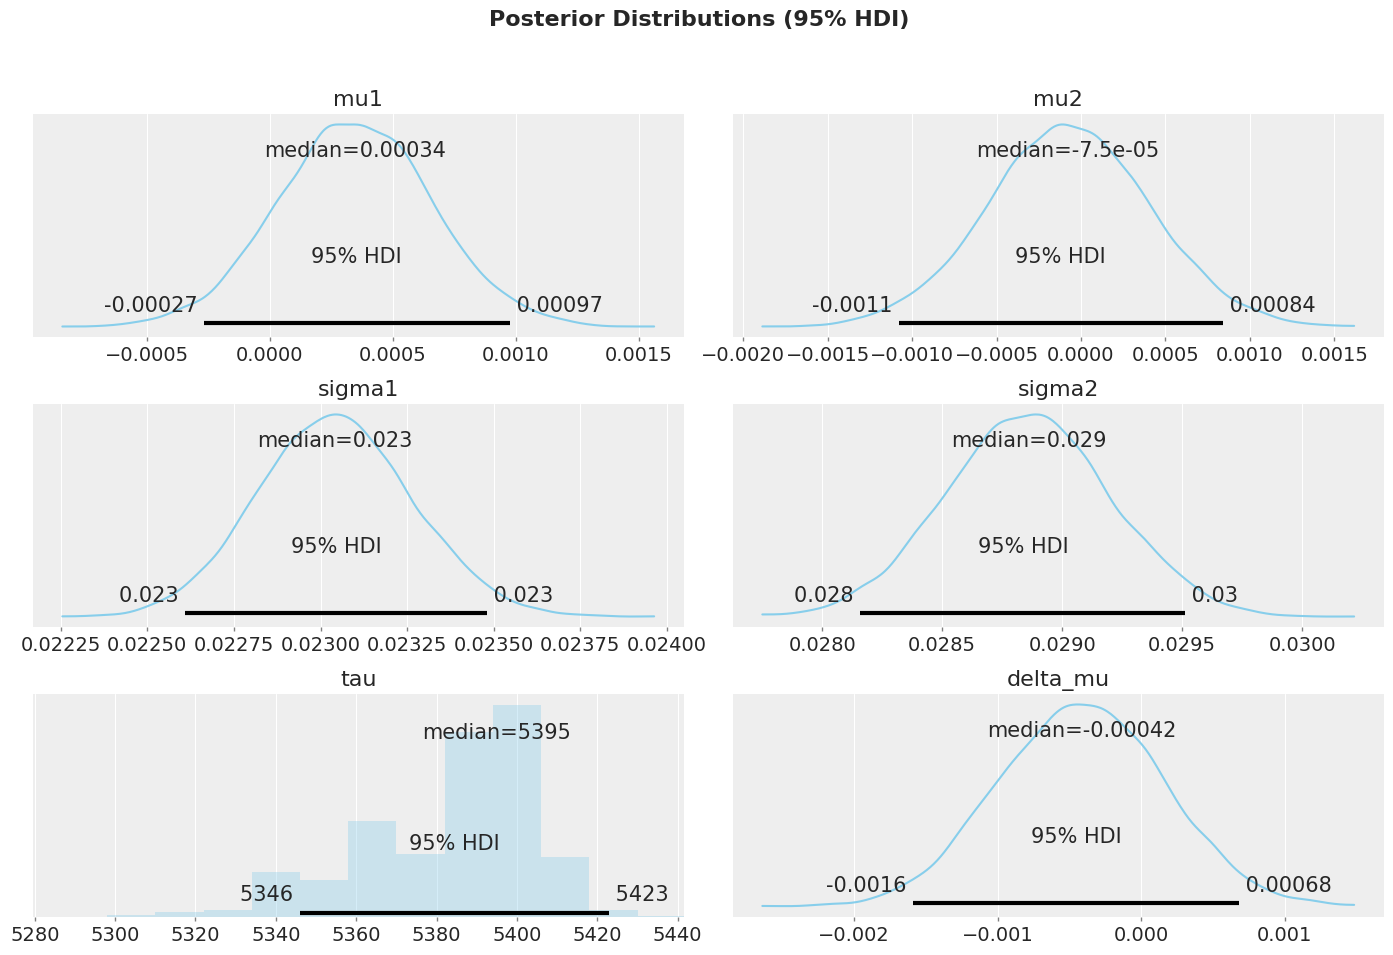

In [47]:
# Create a dedicated figure for Densities
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
az.plot_posterior(
    trace,
    var_names=["mu1", "mu2", "sigma1", "sigma2", "tau", "delta_mu"],
    ax=axes,
    color="skyblue",
    point_estimate='median', # Shows the most likely value
    hdi_prob=0.95            # Shows the 95% Credible Interval
)

plt.suptitle("Posterior Distributions (95% HDI)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

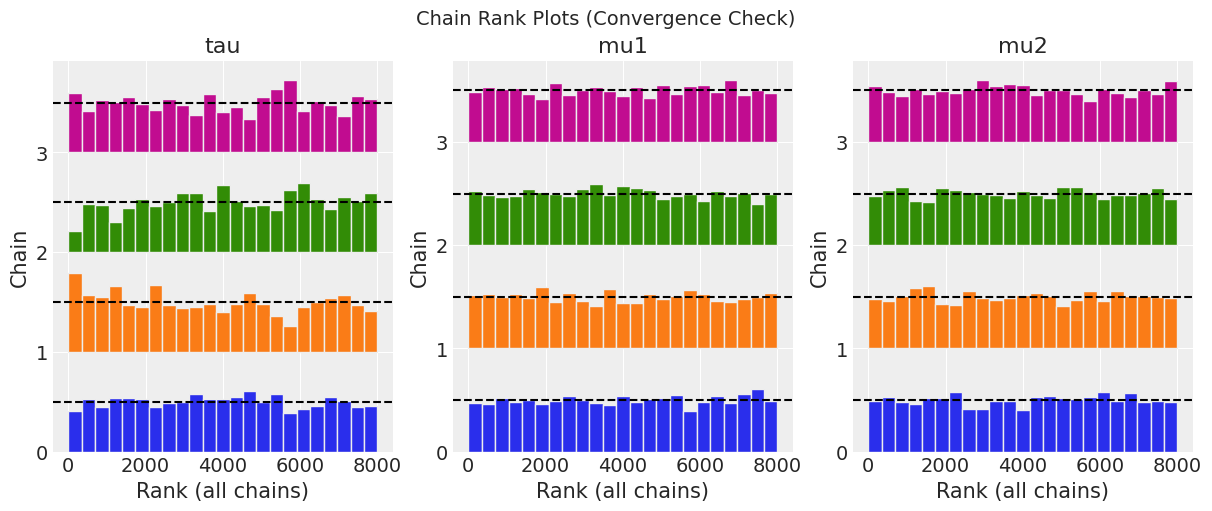

In [48]:
# Rank plots are better than standard traces for visibility
az.plot_rank(trace, var_names=["tau", "mu1", "mu2"], figsize=(12, 5))
plt.suptitle("Chain Rank Plots (Convergence Check)", fontsize=14)
plt.show()

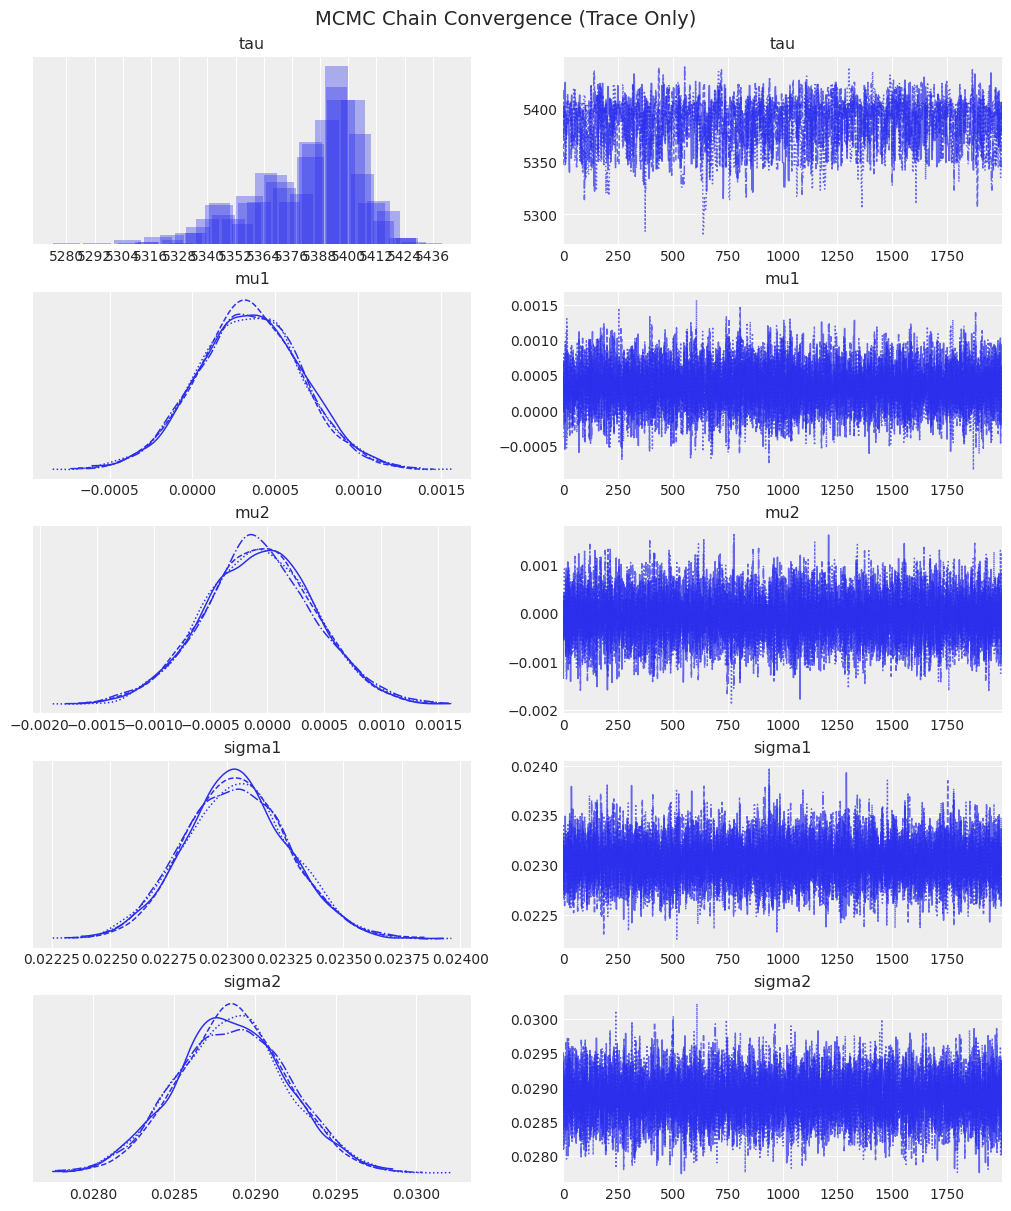

In [49]:
# Plot ONLY the traces (the right side of the default plot)
az.plot_trace(trace,
              var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"],
              kind="trace", # This forces only the lines, no density
              figsize=(10, 12),
              trace_kwargs={"alpha": 0.7})

plt.suptitle("MCMC Chain Convergence (Trace Only)", fontsize=14)
plt.show()

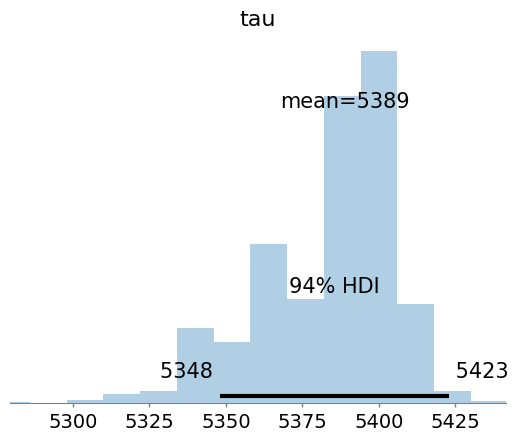

In [27]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()


In [28]:
tau_samples = trace.posterior["tau"].values.flatten()
median_tau = int(np.median(tau_samples))

# +1 because log returns start at index 1
change_date = price_df["date"].iloc[median_tau + 1]

print(f"Detected change point date: {change_date.date()}")


Detected change point date: 2008-08-06


Numeric price impact

In [37]:
pre_prices = price_df[price_df["date"] < change_date]["price"]
post_prices = price_df[price_df["date"] >= change_date]["price"]

mu_pre = pre_prices.mean()
mu_post = post_prices.mean()
pct_change = (mu_post - mu_pre) / mu_pre * 100

print("--- Quantitative Price Impact ---")
print(f"Pre-change mean price:  ${mu_pre:.2f}")
print(f"Post-change mean price: ${mu_post:.2f}")
print(f"Percentage change:     {pct_change:.2f}%")


--- Quantitative Price Impact ---
Pre-change mean price:  $29.82
Post-change mean price: $76.19
Percentage change:     155.54%


In [39]:
WINDOW =7  # days

events_df["days_from_cp"] = (
    events_df["date"] - change_date
).dt.days

associated_events = events_df[
    events_df["days_from_cp"].abs() <= WINDOW
]

associated_events


,date,event_name,category,event_description,days_from_cp
15,2008-08-01,Post-Peak Slide,Economic,Brent prices continued a sharp decline from th...,-5
16,2008-08-07,Russo-Georgian War,Geopolitical,Conflict threatened the BTC pipeline corridor;...,1


Hypothesis statement

In [40]:
if associated_events.empty:
    hypothesis = "No major documented events occurred near the detected change point."
else:
    ev = associated_events.iloc[0]
    hypothesis = (
        f"The detected structural break coincides with "
        f"{ev['event_name']} ({ev['category']}), "
        "which may have influenced oil prices through supply, demand, or risk expectations."
    )

print("Hypothesis:")
print(hypothesis)


Hypothesis:
The detected structural break coincides with Post-Peak Slide (Economic), which may have influenced oil prices through supply, demand, or risk expectations.


Save changepoints.csv

In [41]:
changepoints_df = pd.DataFrame({
    "change_date": [change_date],
    "mean_price_pre": [mu_pre],
    "mean_price_post": [mu_post],
    "percentage_change": [pct_change],
    "associated_event": [associated_events["event_name"].tolist()],
    "hypothesis": [hypothesis]
})

changepoints_df.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/changepoints.csv",
    index=False
)

changepoints_df


,change_date,mean_price_pre,mean_price_post,percentage_change,associated_event,hypothesis
0,2008-08-06,29.81601,76.191557,155.539079,"[Post-Peak Slide, Russo-Georgian War]",The detected structural break coincides with P...


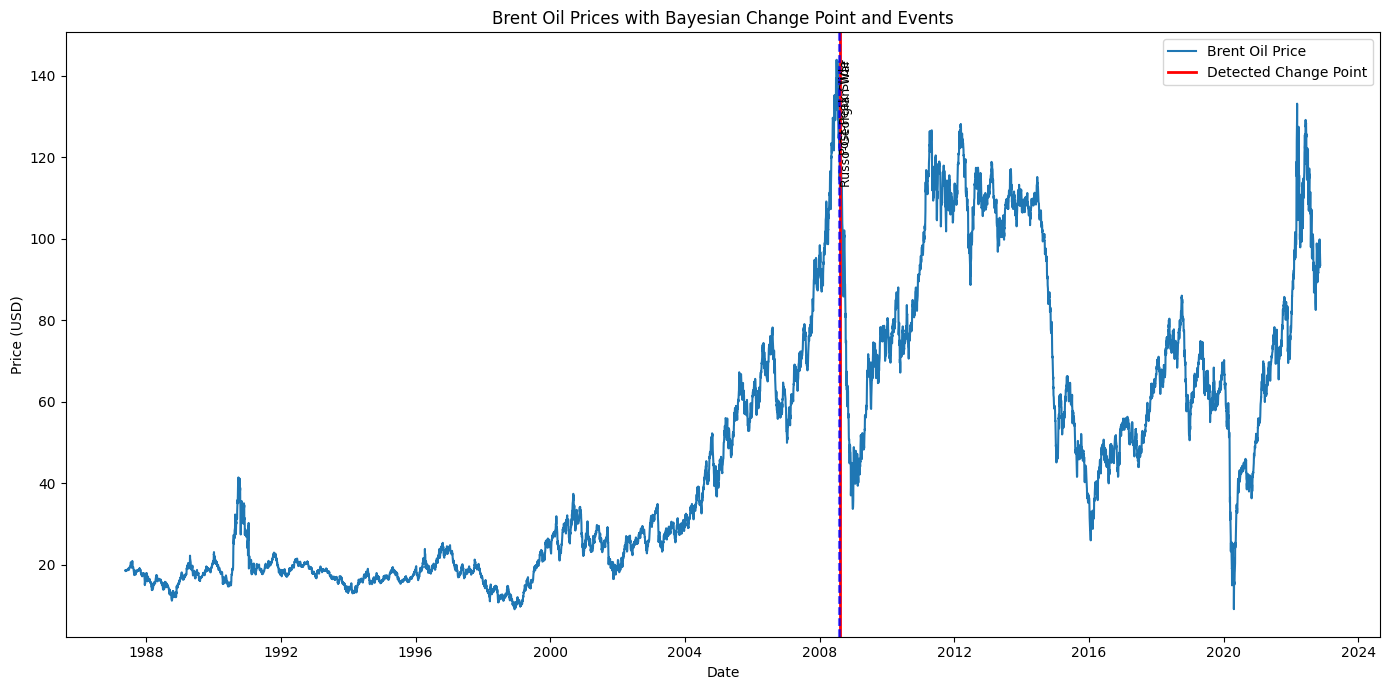

In [43]:
plt.figure(figsize=(14, 7))

plt.plot(price_df["date"], price_df["price"], label="Brent Oil Price")
plt.axvline(change_date, color="red", linewidth=2, label="Detected Change Point")

for _, row in associated_events.iterrows():
    plt.axvline(row["date"], color="blue", linestyle="--", alpha=0.6)
    plt.text(
        row["date"],
        price_df["price"].max(),
        row["event_name"],
        rotation=90,
        fontsize=9,
        verticalalignment="top"
    )

plt.title("Brent Oil Prices with Bayesian Change Point and Events")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()
